### LangGraph, A very basic example


In [10]:
def function3(input3):
    return input3

def function1(input1):
    return input1 + "from first function,"

def function2(input2):
    output=function3("this is third in between,")
    return input2 + " " + output + " and greetings from second function,"

In [11]:
from langgraph.graph import Graph

workflow1=Graph()

workflow1.add_node("function1", function1)
workflow1.add_node("function2",function2)

workflow1.add_edge("function1","function2")

workflow1.set_entry_point("function1")
workflow1.set_finish_point("function2")

app1=workflow1.compile()

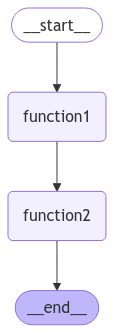

In [5]:
from IPython.display import Image, display

try:
    display(Image(app1.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [6]:
app1.invoke("hi this is Zain ")

'hi this is Zain from first function, this is third in between, and greetings from second function,'

In [7]:
input="hi this is Zain "

for output in app1.stream(input):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from function1
_______
hi this is Zain from first function,


here is output from function2
_______
hi this is Zain from first function, this is third in between, and greetings from second function,




### Now lets create workflow with llm

In [9]:
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph
from langgraph.checkpoint.memory import MemorySaver

llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()
llm.invoke("hi").content

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [248]:
def callingLLM(state: MessagesState):
    #print(f"messages: {state["messages"]}")
    llm = ChatOpenAI(model="gpt-4o-mini")
    response=llm.invoke(state["messages"]).content
    #print(f"response: {response}")
    return {"messages": response}

def textToUpperCase(state: MessagesState):
    #print(f"messages: {state["messages"]}")
    upper_case=state["messages"][-1].content.upper()
    return {"messages": upper_case}

In [249]:
memory = MemorySaver()

workflow2=StateGraph(state_schema=MessagesState)

workflow2.add_node("llm",callingLLM)
workflow2.add_node("upper_string",textToUpperCase)
workflow2.add_edge("llm","upper_string")

workflow2.set_entry_point("llm")
workflow2.set_finish_point("upper_string")

app2=workflow2.compile(checkpointer = memory)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app2.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [251]:
import uuid
config = {"configurable": {"thread_id": uuid.uuid4()}}

# res = app2.invoke({"messages": "My name is Zain, What are you?"}, config)
# res["messages"][-1].content

In [ ]:
# res = app2.invoke({"messages": "what is my name?"}, config)
# res["messages"][-1].content

In [ ]:
input="My name is Zain, what is a name of first Pakistan prime minister? give me only name."

for output in app2.stream({"messages": input}, config):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value["messages"])
        print("\n")

In [ ]:
input="what is my name? give me only name"

for output in app2.stream({"messages": input}, config):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value["messages"])
        print("\n")

### Integrating a RAG Pipeline

In [ ]:
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")
llm.invoke("hi").content

In [255]:
import os
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
# from langchain_community.vectorstores import Chroma
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from typing_extensions import TypedDict
from typing import List
from langgraph.graph import StateGraph, END

In [256]:
# defining the AgentState type
class AgentState(TypedDict):
    question : str
    question_type : str
    answer : str
    documents : list[object]
    vector_store : None
    retriever : None
    json_content : str
    is_valid_json : bool
    

# defining load_document function
def load_document(agentState: AgentState) -> AgentState: 
    print("---DOCUMENT LOAD STARTED---")
    # Specify the root directory where you want to search for PDF files
    filePath = "EcoDocs.pdf"

    # Initialize an empty list to store loaded documents
    docs = []

    # load a single PDF file
    print(filePath)
    pdf_loader = PyPDFLoader(filePath)
    docs = pdf_loader.load()

    agentState['documents'] = docs
    print("---DOCUMENT LOAD COMPLETED---")
    return agentState

# defining split_text function
def split_text(agentState: AgentState) -> AgentState: 
    print("---TEXT SPLITTING STARTED---")
    text_splitter=RecursiveCharacterTextSplitter(
        chunk_size=100,
        chunk_overlap=50
    )
    documents = agentState['documents']
    new_docs = text_splitter.split_documents(documents=documents)
    # doc_strings = [doc.page_content for doc in new_docs]
    agentState['documents'] = new_docs
    print("---TEXT SPLITTING COMPLETED---")
    return agentState

# defining create_vectorStore function
def create_vectorStore(agentState: AgentState) -> AgentState: 
    print("---VECTOR DB CREATION STARTED---")
    documents = agentState['documents']

    if os.path.exists("ecodoc_faissdb"):
        vector_store = FAISS.load_local(folder_path= "ecodoc_faissdb", embeddings=embeddings, allow_dangerous_deserialization=True)
    else:
        vector_store = FAISS.from_documents(
            documents=documents,
            embedding=embeddings
        )
        vector_store.save_local("ecodoc_faissdb")
    agentState['vector_store'] = vector_store
    print("---VECTOR DB CREATION COMPLETED---")
    return agentState

# defining create_retriever function
def create_retriever(agentState: AgentState) -> AgentState:
    print("---RETRIEVER STARTED---") 
    vector_store = agentState['vector_store']
    retriever = vector_store.as_retriever(search_kwargs={"k": 3})
    agentState['retriever'] = retriever
    print("---RETRIEVER COMPLETED---")
    return agentState

# defining get_answer function
def get_answer(agentState: AgentState) -> AgentState: 
    print("---LLM CALLING STARTED---")
    question = agentState['question']
    documents = agentState['documents']
    
    template=""" 
    You are an intelligent assistant. When asked a question, provide the most relevant information from the provided documents.
    If the information is not available, respond that there is no such information in the system files,
    and suggest contacting the helpdesk for further assistance. 
    Do not use any other information than given vector store to provide answers.  
    documents: {documents}
    question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    rag_chain =  {"documents": lambda x: documents, "question": RunnablePassthrough()} | prompt | llm | StrOutputParser()

    generation = rag_chain.invoke(question)

    agentState['answer'] = generation
    print("---LLM CALLING COMPLETED---")
    return agentState




In [257]:

workflow4 = StateGraph(AgentState)
workflow4.add_node("load_document", load_document)
workflow4.add_node("split_text", split_text)
workflow4.add_node("create_vectorStore", create_vectorStore)
workflow4.add_node("create_retriever", create_retriever)
workflow4.add_node("get_answer", get_answer)
workflow4.add_edge('load_document', 'split_text')
workflow4.add_edge('split_text', 'create_vectorStore')
workflow4.add_edge('create_vectorStore', 'create_retriever')
workflow4.add_edge('create_retriever', 'get_answer')
workflow4.set_entry_point("load_document")
workflow4.set_finish_point("get_answer")
app4 = workflow4.compile()

In [ ]:
try:
    display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [ ]:
from pprint import pprint

# defining AgentState Object
inputs = AgentState(
    question = "Let me know about base field?"
)

output = app4.invoke(inputs)

output["answer"]

### More Complex Workflow

In [142]:
# Install the required package
# %pip install jsonschema
import json
from jsonschema import validate
from typing import Literal


def deciding_question_type(agentState: AgentState) -> AgentState:
    print("---LLM CALLING TO DECIDE QUESTION TYPE STARTED---")
    question = agentState['question']
    template=""" 
    You are an intelligent assistant. When asked a question, you need to decide if it is question our user asking to create a
    a form .

    create form means user actually want to create a dynamic input form a page in the application.
    following are examples of create form: 
    example 1: create a form for employee information
    example 2: create a form where in can store crop field attributes
    example 3: create a page for customer's review feedback

    you need to decide which type of question user is asking and then return one of following enum and nothing else.
    question
    creation
    
    question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    rag_chain =  {"question": RunnablePassthrough()} | prompt | llm | StrOutputParser()

    question_type = rag_chain.invoke(question)
    agentState['question_type'] = question_type
    print("---LLM CALLING TO DECIDE QUESTION TYPE COMPLETED---")
    return agentState



def get_form_fields(agentState: AgentState) -> AgentState:
    print("---LLM CALLING TO GENERATE FIELD STARTED---")
    question = agentState['question']
    template=""" 
    You are an intelligent assistant. user ask you to create a form for a specific purpose. you need to create columns
    and their attributes related to the form user ask to create. you need to return a list of columns and their attributes
    you need to generate your answer in json format. column types must be one of following 
    'string', 'integer', 'date', 'decimal'
    return only json and nothing else.

    following is an example of form fields in json format:

    {{
        'columns': [
            {{
                'columnName': 'Name',
                'columnType': 'string',
                'textLength': 50,
                'required'   : true
            }},
            {{
                'name': 'date_of_birth',
                'type': 'date',
                'required': false
            }},
            {{
                'name': 'phone',
                'type': 'integer',
                'required': true
            }}
        ]
    }}
    question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    rag_chain =  { "question": RunnablePassthrough()} | prompt | llm | StrOutputParser()

    json_content = rag_chain.invoke(question)

    agentState['json_content'] = json_content
    # print(json_content )
    print("---LLM CALLING TO GENERATE FIELD COMPLETED---")
    return agentState



def validate_json(agentState: AgentState) -> AgentState:
    print("---VALIDATE JSON STARTED---")
    json_content = agentState['json_content']
    # load json schema from file 'json-schema.json'
    with open('json-schema.json') as f:
        schema = json.load(f)
    # validate json content against schema
    try:
        validate(instance=json.loads(json_content), schema=schema) 
        agentState['is_valid_json'] = True
    except Exception as e:
        agentState['json_content'] = "Invalid JSON content"
        agentState['is_valid_json'] = False
    print(f"---VALIDATE JSON COMPLETED : {agentState['is_valid_json']}---")
    return agentState

def decide_to_regenerate(agentState: AgentState) -> Literal["get_form_fields", "return_answer"]:
    is_valid_json = agentState['is_valid_json']
    if is_valid_json:
        return "return_answer"
    else:
        return "get_form_fields"

def decide_to_reg(agentState: AgentState) -> Literal["load_document", "get_form_fields"]:
    question_type = agentState['question_type']
    if question_type == "question":
        return "load_document"
    else:
        return "get_form_fields"

def return_answer(agentState: AgentState) -> AgentState:
    return agentState

In [143]:
workflow5 = StateGraph(AgentState)

workflow5.add_node("load_document", load_document)
workflow5.add_node("split_text", split_text)
workflow5.add_node("create_vectorStore", create_vectorStore)
workflow5.add_node("create_retriever", create_retriever)
workflow5.add_node("get_answer", get_answer)
workflow5.add_node("deciding_question_type", deciding_question_type)
workflow5.add_node("get_form_fields", get_form_fields)
workflow5.add_node("validate_json", validate_json)
workflow5.add_node("decide_to_regenerate", decide_to_regenerate)
workflow5.add_node("return_answer", return_answer)
workflow5.add_node("decide_to_reg", decide_to_reg)

#workflow5.add_edge('deciding_question_type', 'decide_to_reg')
workflow5.add_conditional_edges('deciding_question_type', decide_to_reg)
# workflow5.add_conditional_edges('decide_to_reg', decide_to_reg)
workflow5.add_edge('get_form_fields', 'validate_json')
workflow5.add_conditional_edges('validate_json', decide_to_regenerate)
workflow5.add_edge('load_document', 'split_text')
workflow5.add_edge('split_text', 'create_vectorStore')
workflow5.add_edge('create_vectorStore', 'create_retriever')
workflow5.add_edge('create_retriever', 'get_answer')
workflow5.add_edge('get_answer', 'return_answer')

workflow5.set_entry_point("deciding_question_type")
workflow5.set_finish_point("return_answer")
app5 = workflow5.compile()

In [ ]:
try:
    display(Image(app5.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)




In [ ]:
from pprint import pprint

# defining AgentState Object
inputs = AgentState(
    #question = "Let me know about base field?"
    question = "create a form for employee information"
)

output = app5.invoke(inputs)

if output["question_type"] == "creation":
    print(output["json_content"])
else:
    print(output["answer"])
